In [1]:
# мне не нравится маркдаун, поэтому я буду комментарии писать в блоках с кодом через `#`

In [2]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt

In [3]:
df = pd.read_csv('clicks_dataset_msk_20230101_20230725_spec.csv', header=None, names=['query', 'object', 'is_positive'])
df.head(5)

,query,object,is_positive
0,1590973,168299,1
1,1590973,718560,0
2,1234953,325828,1
3,1234953,135968,0
4,3326557,334526,1


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12979882 entries, 0 to 12979881
Data columns (total 3 columns):
 #   Column       Dtype
---  ------       -----
 0   query        int64
 1   object       int64
 2   is_positive  int64
dtypes: int64(3)
memory usage: 297.1 MB


In [5]:
df.isna().sum().sum()

0

In [6]:
df.is_positive.value_counts()

1    6489941
0    6489941
Name: is_positive, dtype: int64

In [35]:
df['query'].min(), df['query'].max()

(0, 4520363)

In [36]:
df['object'].min(), df['object'].max()

(0, 1154539)

In [167]:
# индексы идут по порядку, это удобно

In [7]:
df['query'].nunique()

4520364

In [8]:
df['query'].nunique() / len(df)

0.3482592522797973

In [9]:
df['query'].value_counts().head()

1612834    31864
1863671    28594
2798020    22562
1473816    21864
580239     19684
Name: query, dtype: int64

In [11]:
df['query'].value_counts().head(200000)

1612834    31864
1863671    28594
2798020    22562
1473816    21864
580239     19684
           ...  
4263125        4
2112438        4
2343718        4
289471         4
1740182        4
Name: query, Length: 200000, dtype: int64

In [12]:
# довольно много повторяющихся запросов

In [168]:
# посмотрим объекты у самого популярного запроса

In [13]:
most_popular = df.loc[df['query']==1612834, :]
vc = most_popular['object'].value_counts()
vc

611496    3
820952    3
865996    3
415642    3
986351    3
         ..
911601    1
591123    1
980482    1
735250    1
745423    1
Name: object, Length: 31376, dtype: int64

## гипотеза 1

In [14]:
# тк у одного и того же запроса есть повторяющиеся объекты, то возникла гипотеза: 
# таргет (is_positive) может отличаться для одинаковых пар запрос-объект
# Это может происходить по той причине, что мы рандомно выбираем отрицательный сэмпл
# для некоторых пар пара запрос-объект будет иметь класс 0, потому что была выбрана как негативная пара у другой паре запрос-объект

In [15]:
most_popular['vc'] = most_popular['object'].apply(lambda x: vc[x])

C:\Users\basov\AppData\Local\Temp\ipykernel_16716\4267429004.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  most_popular['vc'] = most_popular['object'].apply(lambda x: vc[x])


In [16]:
most_popular.sort_values(by=['vc', 'object', 'is_positive'], ascending=False).head(10)

,query,object,is_positive,vc
6372161,1612834,986351,0,3
7881289,1612834,986351,0,3
12468605,1612834,986351,0,3
6629320,1612834,865996,1,3
9817151,1612834,865996,0,3
12918937,1612834,865996,0,3
571878,1612834,820952,1,3
1120093,1612834,820952,0,3
12069237,1612834,820952,0,3
5102233,1612834,611496,0,3


In [17]:
# так, сразу вижу строки [6629320] и [9817151, 12918937] - одинаковые запросы, но разный таргет
# есть и другие примеры, окей, значит гипотеза подтвердилась
# однако, такая особенность датасета повлияла бы также на метрики в процессе обучения

In [18]:
# но тут есть нюанс, почему на тесте могли получиться предсказания хуже
# у повторяющихся пар запрос-объект будет всегда только 1 положительный сэмпл, а вот
# отрицательных сэмплов может быть много. соответственно, модель будет с большей уверенностью предсказывать 0, нежели 1
# при этом, истинно целевой класс - это 1, поскольку на этот объект кликнул пользователь,
# а все негативные сэмплы были уже сгенерированы

# таким образом, некоторые метрики могла получиться хорошими, в то время как на самом деле, модель абсолютную лажу предсказывала

## гипотеза 2

In [19]:
# недостаточно данных для обучения классических моделей

# пара [запрос_который_был - объект_которого_не_было] как будет обработана моделью?

In [20]:
print(f"Размер матрицы: {df['query'].nunique()} x {df['object'].nunique()}")

Размер матрицы: 4520364 x 1154540


In [21]:
# по сути мы имеем матрицу запросов-объектов размера 4520364 x 1154540

In [22]:
unique_pairs_count = df.groupby(['query', 'object']).size().shape[0]

In [23]:
print(f"Количетсво повторов запрос-объект: {len(df) - unique_pairs_count}")

Количетсво повторов запрос-объект: 3994


In [24]:
print(f"Матрица пуста на {100 * (1 - unique_pairs_count / (df['query'].nunique() * df['object'].nunique()))}%")

Матрица пуста на 99.99975136933202%


In [25]:
# при этом она пуста на ~99.9998%
# что это значит? это значит, что модель классик ML может выучить что-то в имеющихся данных, однако,
# она будет ужасно работать на данных, которые она не видела (как раз те самые пропуски в матрице)

## гипотеза 3

In [26]:
# ложные паттерны в данных, которые нашли модели


# по сути два этих предиктора - это не интервальные, а категориальные значения
# некоторые алгоритмы могут совершенно неправильно интерпретировать эти значения

# например, логрег: a_0 + a_1 * x_1 + a_2 * x_2 = y  -- понятно, что эта логика не имеет смысла, посколько хоть
# у нас и численные переменные, такая взаимосвязь ошибочна.

# дерево решений тоже может найти ложные закономерности: сравнивать как-то ID запросов и объектов 
# и на основе их значений выдавать какой-то результат - бессмысленно
# да, может получиться так, что если у объекта id меньше 820952, то он всегда будет давать негативный результат
# с точки зрения интерпретации - это ошибочная логика

In [27]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score, cross_validate
from sklearn.tree import DecisionTreeClassifier

In [28]:
X = df.drop(['is_positive'], axis=1)
y = df['is_positive']

In [29]:
clf = LogisticRegression(random_state=42)
scores = cross_validate(clf, X, y, cv=5, scoring=['precision', 'recall', 'accuracy'],
                        return_train_score=True, return_estimator=True)
scores

{'fit_time': array([11.86765218, 11.66815519, 11.85349655, 12.05007744, 12.00210166]),
 'score_time': array([2.2825954 , 2.32571125, 2.06446004, 2.22194052, 2.12541199]),
 'estimator': [LogisticRegression(random_state=42),
  LogisticRegression(random_state=42),
  LogisticRegression(random_state=42),
  LogisticRegression(random_state=42),
  LogisticRegression(random_state=42)],
 'test_precision': array([0.63345846, 0.63332056, 0.63282084, 0.6339642 , 0.63317006]),
 'train_precision': array([0.63333831, 0.63332689, 0.63348454, 0.63317633, 0.63341752]),
 'test_recall': array([0.48180146, 0.48240199, 0.48212618, 0.48346518, 0.48212541]),
 'train_recall': array([0.48250176, 0.48243869, 0.48244408, 0.48214265, 0.48240171]),
 'test_accuracy': array([0.60150687, 0.60155078, 0.601192  , 0.60216196, 0.60140194]),
 'train_accuracy': array([0.60158235, 0.60156213, 0.60165809, 0.60140933, 0.60160887])}

In [30]:
print(f"bias: {scores['estimator'][0].intercept_[0]}")
print(f"{scores['estimator'][0].feature_names_in_} weights: {scores['estimator'][0].coef_[0]}")

bias: 3.875227816661139e-13
['query' 'object'] weights: [ 1.80261141e-07 -1.04965744e-06]


In [31]:
# видим, что получилось какое-то уравнение: y_prob = sigmoid(query*1.80261141e-07 - object*1.04965744e-06 + 3.875227816661139e-13)
# это всего лишь линейное уравнение, поэтому его accuracy около 60, и это на кросс-валидации
# на реальных данных все предсказания такой модели будут практически случайные, поскольку она нашла зависимость там, где ее нет

## гипотеза 4

In [32]:
# сдвиг в распределении данных

# отсутствие временной метки в данных
# запросы могли меняться со временем, какие-то объекты могли становиться популярнее
# тренды, которые могли выучить модели на обучающих данных, уже будут неактуальны на этапе применения модели

# данные могли быть собраны из определенных источников, а тестироваться в других условиях

# поведение пользователей и контекст, в котором он взаимодействует с системой, могли поменться со временем

## гипотеза 5

In [39]:
# отсутствие в целом каких-то контекстных данных, по типу местоположения, демографические данные и др.

# если использовались алгоритмы ALS или другие, рассматривающие только взаимодействие запроса и объекта,
# то такие алгоритмы игнорируют важные параметры, которые находятся за пределами простой матрицы взаимодействий

In [169]:
# попробуем обучить ALS на этих данных, кросс-валидацией


# ATTENTION: код не запускал, потому что не смог бы ничего сказать, получив какие-то метрики у ALS (и он очень долго выполнялся)

In [ ]:
from scipy.sparse import csr_matrix
from implicit.als import AlternatingLeastSquares
from sklearn.model_selection import KFold
from sklearn.metrics import precision_score, recall_score, accuracy_score

In [ ]:
rows = df['query'].map({query: i for i, query in enumerate(df['query'].unique())})
cols = df['object'].map({obj: i for i, obj in enumerate(df['object'].unique())})
values = df['is_positive']
matrix = csr_matrix((values, (rows, cols)), shape=(df['query'].nunique(), df['object'].nunique()))

In [ ]:
threshold = 0.5

kf = KFold(n_splits=5)
precision_values, recall_values, accuracy_values = [], [], []

for train_index, test_index in kf.split(matrix):
    train = matrix[train_index]
    test = matrix[test_index]

    model = AlternatingLeastSquares(factors=50)
    model.fit(train)

    # рейтинги для тестового набора
    predicted = model.predict(test_index, np.arange(matrix.shape[1]))
    binarized_predicted = [1 if pred >= threshold else 0 for pred in predicted]
    
    # фактические метки
    actual = test[test.nonzero()].toarray().flatten()

    precision_values.append(precision_score(actual, binarized_predicted))
    recall_values.append(recall_score(actual, binarized_predicted))
    accuracy_values.append(accuracy_score(actual, binarized_predicted))

print(f"Средняя точность: {np.mean(precision_values)}")
print(f"Средняя полнота: {np.mean(recall_values)}")
print(f"Средняя точность: {np.mean(accuracy_values)}")

## гипотеза 6

In [41]:
# кросс-валидация была настроена таким образом, что валидационные поднаборы данных слишком похожи на тренировочные данные,
# это могло привести к чрезмерной уверенности в эффективности модели

## гипотеза 7

In [42]:
# негативные примеры на самом деле не негативные

# могло получиться так, что примеры находятся в соседних рубриках, либо как-то по-другому связаны
# из-за этого, ставить метку `0` в ячейку взаимодействия запроса и такого псевдонегативного объекта - ошибка

## гипотеза 8

In [81]:
only_positive = df.loc[df['is_positive'] == 1, :]
only_negative = df.loc[df['is_positive'] == 0, :]

In [82]:
pos_vc = only_positive['object'].value_counts()
sorted_pos_vc = pos_vc.sort_values(ascending=False).reset_index()

In [83]:
sorted_pos_vc.head()

,index,object
0,135367,2838
1,161420,2698
2,128803,1994
3,91490,1947
4,356746,1926


In [84]:
# есть объекты, которые пользуются большим спросом

In [85]:
sorted_pos_vc = pos_vc.sort_values(ascending=True).reset_index()

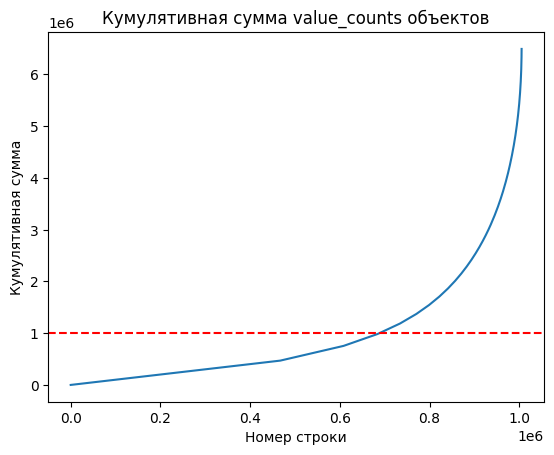

In [86]:
plt.plot(np.cumsum(sorted_pos_vc['object']))
plt.axhline(y=1e6, color='r', linestyle='--')
plt.title('Кумулятивная сумма value_counts объектов')
plt.xlabel('Номер строки')
plt.ylabel('Кумулятивная сумма')
plt.show()

In [87]:
# большая часть объектов все же встречается по одному разу,
# однако существенная часть объектов встречается по большому количеству раз

# если бы все объекты встречались по одному разу, то красная линия пересекла бы синию в точке (1e6, 1e6)

In [90]:
# соответственно, модель могла переобучиться под более популярные объекты

In [91]:
pos_vc.sort_values(ascending=False).reset_index().head(5)

,index,object
0,135367,2838
1,161420,2698
2,128803,1994
3,91490,1947
4,356746,1926


In [92]:
# к тому же, у первых двух объектов значения сильно выше, чем у всех остальных
# это может быть из-за различного процесса сбора данных, либо данные были собраны в периоды акции на эти два объекта
# либо что-то подобное

In [93]:
neg_vc = only_negative['object'].value_counts()
sorted_neg_vc = neg_vc.sort_values(ascending=False).reset_index()
sorted_neg_vc.head()

,index,object
0,666165,35
1,830560,34
2,428775,34
3,880286,33
4,700568,33


In [150]:
# негативные объекты тоже повторяются, но гораздо менее часто, чем положительные объекты

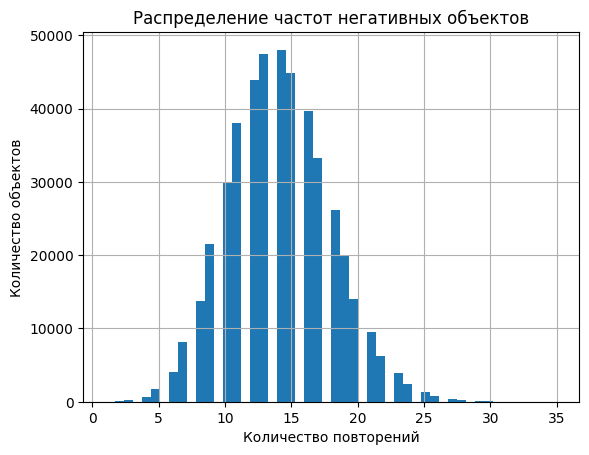

In [165]:
sorted_neg_vc['object'].hist(bins=50)
plt.title('Распределение частот негативных объектов')
plt.xlabel('Количество повторений')
plt.ylabel('Количество объектов')
plt.show()

In [163]:
# распределение частот негативных примерно нормальное, это может значит, что негативные сэмплы в самом деле выбирались случайно

## гипотеза 9

In [107]:
# теперь проверим аналогично запросы

In [106]:
pos_vc = only_positive['query'].value_counts()
sorted_pos_vc = pos_vc.sort_values(ascending=False).reset_index()
sorted_pos_vc.head()

,index,query
0,1612834,15932
1,1863671,14297
2,2798020,11281
3,1473816,10932
4,580239,9842


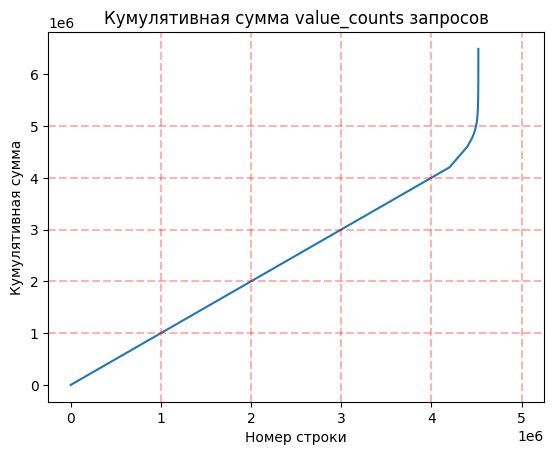

In [112]:
sorted_pos_vc = pos_vc.sort_values(ascending=True).reset_index()
plt.plot(np.cumsum(sorted_pos_vc['query']))
plt.axhline(y=1e6, color='r', linestyle='--', alpha=0.3)
plt.axvline(x=1e6, color='r', linestyle='--', alpha=0.3)
plt.axhline(y=2e6, color='r', linestyle='--', alpha=0.3)
plt.axvline(x=2e6, color='r', linestyle='--', alpha=0.3)
plt.axhline(y=3e6, color='r', linestyle='--', alpha=0.3)
plt.axvline(x=3e6, color='r', linestyle='--', alpha=0.3)
plt.axhline(y=4e6, color='r', linestyle='--', alpha=0.3)
plt.axvline(x=4e6, color='r', linestyle='--', alpha=0.3)
plt.axhline(y=5e6, color='r', linestyle='--', alpha=0.3)
plt.axvline(x=5e6, color='r', linestyle='--', alpha=0.3)
plt.title('Кумулятивная сумма value_counts запросов')
plt.xlabel('Номер строки')
plt.ylabel('Кумулятивная сумма')
plt.show()

In [141]:
# судя по графику, ситуация такая, что большинство запросов встречаются по одному разу (~4млн), но есть не так много,
# которые встречаются очень много раз

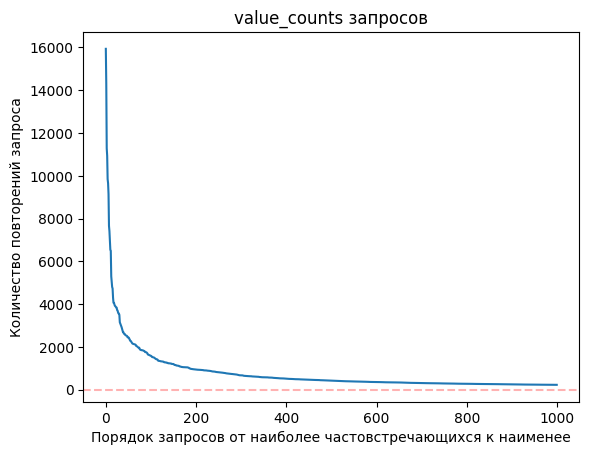

In [137]:
pos_vc.sort_values(ascending=False).reset_index().head(1000)['query'].reset_index(drop=True).plot()
plt.axhline(y=1, color='r', linestyle='--', alpha=0.3)
plt.title('value_counts запросов')
plt.xlabel('Порядок запросов от наиболее частовстречающихся к наименее')
plt.ylabel('Количество повторений запроса')
plt.show()

In [145]:
# первые ~100-150 запросов по популярности сильно превосходят остальные, что может не отражаться на реальных данных
# для этих запросов есть много данных, и для них модель могла отрабатывать хорошо
# при этом метрики тоже могли быть лучше, чем на самом деле, поскольку модель будет верно предсказывать для популярных запросов

# также, популярность именно этих запросов могла быть обеспечена внешними условиями (время, сезон, погода, чрезвычайная ситуация)
# соответственно, на момент применения модели, усолвия могли быть другими и эти запросы перестали быть самыми популярными
# и тот скор, который модель получила во время валидации фактически обнулится, потому что в существенной степени он был обеспечен
# популярными запросами